In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import cv2
import tensorflow as tf

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
tf.config.list_physical_devices('GPU')

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import utils

### Getting Your data In

(48, 48, 3)


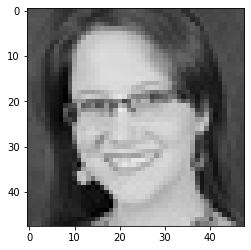

In [4]:
img_example = cv2.imread(r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer_directory\Training\Happy\7.jpg')
img_example
print(img_example.shape)
plt.imshow(img_example);

In [5]:
train_images_path = r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer_directory\Training'
valid_images_path = r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer_directory\Validation'

In [6]:
csv_path = r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer2013\fer2013.csv'

### Via Keras's ImageDataGeneratorClass

In [7]:
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)

In [8]:
gen = ImageDataGenerator()

In [9]:
aug_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)

In [10]:
# zoom_range=0.2, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2

#### ImageDataGenerator Method 1:
`Flow From Directory`

In [11]:
train_flow = train_gen.flow_from_directory(train_images_path, color_mode='grayscale', target_size=(48, 48))

Found 28709 images belonging to 7 classes.


In [12]:
valid_flow = valid_gen.flow_from_directory(valid_images_path, color_mode='grayscale', target_size=(48, 48))

Found 3589 images belonging to 7 classes.


#### ImageDataGenerator Method 2:
`Flow (From Array)`

In [13]:
df = pd.read_csv(csv_path)

In [14]:
df.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [15]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [16]:
df['pixels'] = df.pixels.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((48,48,1)))

3


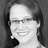

In [17]:
i = 7
print(df['emotion'][i])
array_to_img(df['pixels'][i].reshape((48,48,1)))

In [18]:
def convert_to_array(s):
    arr = np.array(list(s)).reshape((-1,48,48,1))
    return arr

In [19]:
cw = df[df.Usage=='Training'].emotion.value_counts()
class_weight_dict = dict(cw/sum(cw))

In [20]:
def train_val_test_split(data):
    train = data[data.Usage=='Training']
    val = data[data.Usage=='PublicTest']
    test = data[data.Usage=='PrivateTest']
    x_train, y_train = train['pixels'], train['emotion']
    x_val, y_val = val['pixels'], val['emotion']
    x_test, y_test = test['pixels'], test['emotion']
    return convert_to_array(x_train), convert_to_array(x_val), convert_to_array(x_test), utils.to_categorical(y_train, num_classes=7),  utils.to_categorical(y_val, num_classes=7),  utils.to_categorical(y_test, num_classes=7)

In [21]:
x_train, x_val, x_text, y_train, y_val, y_test = train_val_test_split(df)

In [22]:
aug_gen.fit(x_train)

In [23]:
Aug_flow = aug_gen.flow(x_train, y_train, batch_size=64)

In [24]:
val_flow = valid_gen.flow(x_val, y_val, batch_size=64)

### Via OpenCV2 & OS module

In [25]:
train_x, valid_x, train_y, valid_y = [], [], [], []

In [26]:
classes = [category for category in os.listdir(train_images_path)]

In [27]:
for category in os.listdir(train_images_path):
    cat_path = os.path.join(train_images_path, category)
    for image in os.listdir(cat_path):
        img_path = os.path.join(cat_path, image)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img, (48,48))
        train_x.append(img_array)
        train_y.append(classes.index(category))

In [28]:
train_y = utils.to_categorical(np.array(train_y), num_classes=7)

In [29]:
train_x = np.array(train_x).reshape(-1, 48, 48, 1)

In [30]:
train_x.shape

(28709, 48, 48, 1)

In [31]:
train_y.shape

(28709, 7)

In [32]:
for category in os.listdir(valid_images_path):
    cat_path = os.path.join(valid_images_path, category)
    for image in os.listdir(cat_path):
        img_path = os.path.join(cat_path, image)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img, (48,48))
        valid_x.append(img_array)
        valid_y.append(classes.index(category))

In [33]:
valid_y = utils.to_categorical(np.array(valid_y), num_classes=7)

In [34]:
valid_x = np.array(valid_x).reshape(-1, 48, 48, 1)

### Models

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [37]:
BATCH_SIZE = 64
EPOCHS = 100

In [38]:
emo_model = Sequential()

emo_model.add(Conv2D(input_shape=train_flow.image_shape, filters=64, kernel_size=(3,3), activation='relu', data_format='channels_last', kernel_regularizer=l2(0.01)))
emo_model.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(MaxPooling2D(pool_size=(2,2)))
emo_model.add(Dropout(0.5))

emo_model.add(Conv2D(filters=128, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(Conv2D(filters=128, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(MaxPooling2D(pool_size=(2,2)))
emo_model.add(Dropout(0.5))

emo_model.add(Conv2D(filters=256, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(Conv2D(filters=256, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(MaxPooling2D(pool_size=(2,2)))
emo_model.add(Dropout(0.5))

emo_model.add(Flatten())

# emo_model.add(Dense(1024, activation='relu'))
# emo_model.add(Dropout(0.2))

emo_model.add(Dense(train_flow.num_classes, activation="softmax"))


In [39]:
emo_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss=categorical_crossentropy, metrics=['accuracy'])

In [40]:
emo_model.fit(Aug_flow, 
              epochs=EPOCHS, 
#               batch_size=BATCH_SIZE,
              steps_per_epoch=Aug_flow.n//Aug_flow.batch_size,
              validation_data = val_flow,
              validation_steps = val_flow.n//val_flow.batch_size,
              callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)],
              shuffle=True)

Epoch 1/100


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-40-e0f4fd78498b>:1) ]] [Op:__inference_train_function_2083]

Function call stack:
train_function


In [40]:
emo_model.fit(train_flow, 
              epochs=30, 
              steps_per_epoch=train_flow.n//train_flow.batch_size, 
              validation_data = valid_flow, 
              validation_steps = valid_flow.n//valid_flow.batch_size,
              callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)]
             )

Epoch 1/30
897/897 [==============================] - 27s 30ms/step - loss: 2.2749 - accuracy: 0.2910 - val_loss: 1.6618 - val_accuracy: 0.3680
Epoch 2/30
897/897 [==============================] - 26s 29ms/step - loss: 1.5370 - accuracy: 0.4175 - val_loss: 1.7250 - val_accuracy: 0.3730
Epoch 3/30
897/897 [==============================] - 26s 29ms/step - loss: 1.3440 - accuracy: 0.4892 - val_loss: 1.4398 - val_accuracy: 0.4587
Epoch 4/30
897/897 [==============================] - 27s 30ms/step - loss: 1.2520 - accuracy: 0.5298 - val_loss: 1.3092 - val_accuracy: 0.4880
Epoch 5/30
897/897 [==============================] - 27s 30ms/step - loss: 1.1886 - accuracy: 0.5565 - val_loss: 1.3473 - val_accuracy: 0.4989
Epoch 6/30
897/897 [==============================] - 27s 30ms/step - loss: 1.1323 - accuracy: 0.5781 - val_loss: 1.1452 - val_accuracy: 0.5762
Epoch 7/30
897/897 [==============================] - 27s 30ms/step - loss: 1.0910 - accuracy: 0.5914 - val_loss: 1.1267 - val_accuracy:

In [40]:
emo_model.fit(train_flow, 
              epochs=100, 
              steps_per_epoch=train_flow.n//train_flow.batch_size, 
              validation_data = valid_flow, 
              validation_steps = valid_flow.n//valid_flow.batch_size,
              callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)],
              class_weight = class_weight_dict
             )

Epoch 1/100
897/897 [==============================] - 28s 31ms/step - loss: 0.4519 - accuracy: 0.2686 - val_loss: 9.6063 - val_accuracy: 0.1362
Epoch 2/100
897/897 [==============================] - 27s 31ms/step - loss: 0.2727 - accuracy: 0.3688 - val_loss: 1.5880 - val_accuracy: 0.3669
Epoch 3/100
897/897 [==============================] - 28s 31ms/step - loss: 0.2230 - accuracy: 0.4397 - val_loss: 1.6243 - val_accuracy: 0.4224
Epoch 4/100
897/897 [==============================] - 28s 31ms/step - loss: 0.1993 - accuracy: 0.4918 - val_loss: 1.4665 - val_accuracy: 0.4584
Epoch 5/100
897/897 [==============================] - 28s 31ms/step - loss: 0.1852 - accuracy: 0.5256 - val_loss: 1.4319 - val_accuracy: 0.4980
Epoch 6/100
897/897 [==============================] - 29s 33ms/step - loss: 0.1752 - accuracy: 0.5472 - val_loss: 1.1918 - val_accuracy: 0.5550
Epoch 7/100
897/897 [==============================] - 29s 32ms/step - loss: 0.1659 - accuracy: 0.5697 - val_loss: 1.3977 - val_ac